## TODO
- Figure out how to deal with self intersecting cells
- Implement odor gradient control
- Use a different library for faster animation (maybe raylib or pygame, opensim)
- 3D extension

In [1]:
%matplotlib widget
import cvxpy as cp
import numpy as np

import hydrostat_arm as ha
import draw_nodes
import obstacle

import importlib

# Model Assumptions
1. Every cell maintains a constant volume/area. 
2. Cell edges are not springs, but they are dampers.
3. Muscles may pull, but not push.
4. The base of the arm has pinned boundary conditions for the bottom vertices.

The cell dynamics follow the following model.
$$
\ddot{q} = M^{-1} (F_e + F_i + \hat F - B\dot q - \beta (q, \dot q)) \\
\begin{align*}
\text{subject to } &V = V_0 \\
& F_i \ge 0 \\
& \dot q_\text{base} = 0
\end{align*}
$$

Where $q$ is the $x, y$ position of each vertex, $M$ is a diagonal matrix of vertex masses, $F_e$ are external forces acting on vertices (user defined or collisions), $F_i$ are internal forces generated by muscle activation, $\hat F$ are reaction forces generated by the constant volume constraint, $B$ is a diagonal matrix of damping coefficients for the vertices (viscosity), $\beta$ are linear damping forces from edge contraction/extension, and $V$ and $V_0$ are the current and initial cell volumes.

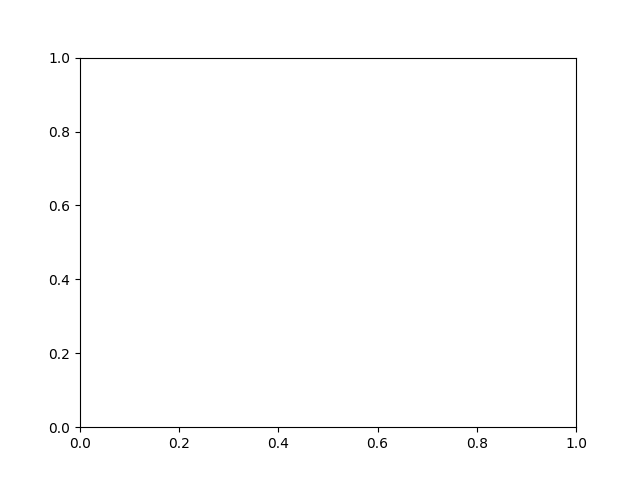

In [3]:
importlib.reload(ha)
importlib.reload(draw_nodes)

def straight_arm_maker(height):
    vertices = [[0, 0], [1, 0]]
    for idx in range(height):
        vertices.append([0, (idx+1)*1])
        vertices.append([1, (idx+1)*1])
    vertex_indices = np.arange(len(vertices))
    cells = np.array([[i, j, k] for i, j, k in zip(vertex_indices[:-2], vertex_indices[1:-1], vertex_indices[2:])])
    return np.array(vertices), cells

vertices, cells = straight_arm_maker(10)
vertices = np.array([[0,0], [1, 0], [1, 1]])
cells = np.array([[0, 1, 2]])
# dofs = {0: [1, 0], 1: [0, 0], 2:[1, 0]}
# arm = ha.HydrostatArm(vertices, cells, dofs)
arm = ha.HydrostatArm(vertices, cells)

def odor(x, y):
    x = np.array(x)
    y = np.array(y)
    food_loc = np.array([10, 10])
    covar = np.eye(2)*10
    offset = np.array([[x - food_loc[0], y - food_loc[1]]]).T
    product = (offset.swapaxes(-2, -1) @ np.linalg.inv(covar) @ offset).T
    return np.exp(-0.5 * np.squeeze(product))# / ((2*np.pi)**2 * np.linalg.det(covar))**0.5

# arm.odor_func = odor

obstacle_vertices = np.array([
    [2, 7],
    [2, 0],
    [5, 0],
    [5, 7],
    [3.5, 8]
])
obst = obstacle.ConvexObstacle(obstacle_vertices)
arm.add_obstacle(obst)

obstacle_vertices = np.array([
    [2, 16],
    [2, 11],
    [3.5, 10],
    [5, 11],
    [5, 16]
])
obst = obstacle.ConvexObstacle(obstacle_vertices)
arm.add_obstacle(obst)


drawer = draw_nodes.NodeDrawer(arm)

In [3]:
print(arm.cell_volume(arm.vertices[arm.cells[-1]]))

print(np.max(arm.errors))
print(np.max(arm.errors[-1]))
print(arm.constraints().shape)
print(arm.jacobian_derivative().shape)


-0.49999904291631125
0.0038903123221416536
8.01726210042375e-06
(26,)
(26, 44)


# Explicit Example

The below sections display an example of the hydrostatic arm calculations more procedurally.

In [ ]:
import numpy as np
# Constrained Optimization with inequality constraints

simulation_steps = 2000
dt = 0.01
t = np.arange(0, (simulation_steps+1) * dt, dt)

dim = 2
q0 = np.array([0, 0, 1, 0, 0, 1, 1, 1])
num_nodes = len(q0)//dim
dq0 = np.zeros(num_nodes * dim)
M = np.diag(np.ones(num_nodes * dim))
W = np.linalg.inv(M)
B = np.diag(np.ones(num_nodes * dim))
Q = np.zeros((simulation_steps, num_nodes*dim))
Q[:len(Q)//2,4] = np.ones((simulation_steps//2))/2
Q[len(Q)//2:,4] = -np.ones((simulation_steps//2))/2
F = np.zeros((simulation_steps, 5))
ks = 100
kd = 10

def cell_volume(q):
    return 0.5 * ((q[2] - q[0]) * (q[5] - q[1]) - (q[3] - q[1]) * (q[4] - q[0]))

wall = 1.5
def C(q):
    """Returns an mx1 numpy array of constraints. Each constraint is set equal
    to zero."""
    if q[6] >= wall:
        return np.array([
        cell_volume(q[0:6]) - cell_volume(q0[0:6]),
        q[0],
        q[1],
        cell_volume(q[2:8]) - cell_volume(q0[2:8]),
        q[6] - wall
        ])
    return np.array([
        cell_volume(q[0:6]) - cell_volume(q0[0:6]),
        q[0],
        q[1],
        cell_volume(q[2:8]) - cell_volume(q0[2:8]),
    ])

def jacobian(q):
    """Returns an m x n jacobian where m is the number of constraints and n is
    the length of the state vector. Each element is the partial derivative
    pC_i/pq_j"""
    if q[6] >= wall:
        return np.array([[
            0.5*(q[3] - q[5]),
            0.5*(q[4] - q[2]),
            0.5*(q[5] - q[1]),
            0.5*(q[0] - q[4]),
            0.5*(q[1] - q[3]),
            0.5*(q[2] - q[0]),
            0, 0],

            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            
            [0, 0,
            0.5*(q[5] - q[7]),
            0.5*(q[6] - q[4]),
            0.5*(q[7] - q[3]),
            0.5*(q[2] - q[6]),
            0.5*(q[3] - q[5]),
            0.5*(q[4] - q[2])],
            [0, 0, 0, 0, 0, 0, 1, 0]
            ])
    return np.array([[
        0.5*(q[3] - q[5]),
        0.5*(q[4] - q[2]),
        0.5*(q[5] - q[1]),
        0.5*(q[0] - q[4]),
        0.5*(q[1] - q[3]),
        0.5*(q[2] - q[0]),
        0, 0],

        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        
        [0, 0,
        0.5*(q[5] - q[7]),
        0.5*(q[6] - q[4]),
        0.5*(q[7] - q[3]),
        0.5*(q[2] - q[6]),
        0.5*(q[3] - q[5]),
        0.5*(q[4] - q[2])],
        ])

def dJ(q, dq):
    """Returns an m x n matrix of derivatives dJ/dt. This would technically be
    a rank 3 tensor, but can be represented by the mxn p(pC/pq dq/dt)/pq"""
    if q[6] >= wall:
        return np.array([[
            0.5*(dq[3] - dq[5]),
            0.5*(dq[4] - dq[2]),
            0.5*(dq[5] - dq[1]),
            0.5*(dq[0] - dq[4]),
            0.5*(dq[1] - dq[3]),
            0.5*(dq[2] - dq[0]),
            0, 0],

            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],

            [0, 0,
            0.5*(dq[5] - dq[7]),
            0.5*(dq[6] - dq[4]),
            0.5*(dq[7] - dq[3]),
            0.5*(dq[2] - dq[6]),
            0.5*(dq[3] - dq[5]),
            0.5*(dq[4] - dq[2])],

            [0, 0, 0, 0, 0, 0, 0, 0],
        ])
    return np.array([[
        0.5*(dq[3] - dq[5]),
        0.5*(dq[4] - dq[2]),
        0.5*(dq[5] - dq[1]),
        0.5*(dq[0] - dq[4]),
        0.5*(dq[1] - dq[3]),
        0.5*(dq[2] - dq[0]),
        0, 0],

        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],

        [0, 0,
        0.5*(dq[5] - dq[7]),
        0.5*(dq[6] - dq[4]),
        0.5*(dq[7] - dq[3]),
        0.5*(dq[2] - dq[6]),
        0.5*(dq[3] - dq[5]),
        0.5*(dq[4] - dq[2])],
    ])

qs = np.empty((simulation_steps+1, num_nodes*dim))
dqs = np.empty((simulation_steps+1, num_nodes*dim))
qs[0] = q0
dqs[0] = dq0

for idx in range(simulation_steps):
    q = qs[idx]
    dq = dqs[idx]
    J = jacobian(q)
    lagrange_mult = (
        np.linalg.inv(J @ W @ J.T)
        @ ((J @ W @ B - dJ(q, dq)) @ dq - J @ W @ Q[idx] - ks * C(q) - kd * J @ dq)
    )


    reactions = J.T @ lagrange_mult
    ddq = W @ (Q[idx] + reactions - B @ dq)
    dqs[idx+1] = dq + ddq * dt
    qs[idx+1] = q + dq * dt


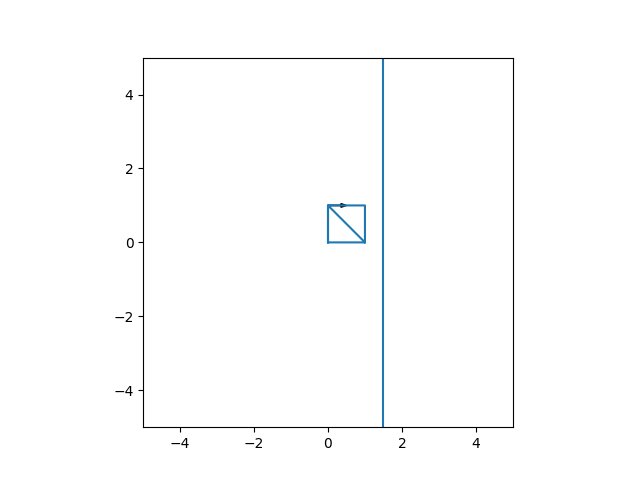

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import animation

def get_triangle_coords(q):
    return ([q[0], q[2], q[4], q[0]], [q[1], q[3], q[5], q[1]])

def get_net_coords(q):
    return ([q[0], q[2], q[4], q[0], q[4], q[6], q[2]], [q[1], q[3], q[5], q[1], q[5], q[7], q[3]])

fig, ax = plt.subplots()
ax.axvline(1.5)
ax.set_aspect('equal')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
# tri, = ax.plot(*get_triangle_coords(qs[0]))
net, = ax.plot(*get_net_coords(qs[0]))
arrow = ax.arrow(qs[0,4], qs[0,5], Q[0,4], Q[0,5], length_includes_head=True, head_width=.1)


def update(frame):
    # tri.set_data(*get_triangle_coords(qs[frame]))
    net.set_data(*get_net_coords(qs[frame]))
    arrow.set_data(x=qs[frame, 4], y=qs[frame, 5], dx=Q[frame, 4], dy=Q[frame,5])
    return net, arrow,

ani = animation.FuncAnimation(fig, update, frames=simulation_steps, interval=int(dt*1000))
# ani.save('triangle_animation.mp4')


In order to generalize the hydrostat model for cells that are not simplices (not triangles, tetrahedrons, etc) and for 3D polytopes, it is necessary to define general volume constraints, facet constraints (planar points must remain planar), and self intersection constraints (vertices going through arm edges). 

## General volume calculation
There are three proposed methods of calculating the volume constraint.
1. Use the Qhull methods via scipy wrapper. Pros: out of the box way to calculate volume. Cons: unable to update point coordinates, so new objects must be created for each cell at each time step. Probably slow. Also, not easily differentiable for calculating the Jacobian.
2. Triangulate the shape into simplices, calculate each individual tetrahedron, and then sum the volumes. Pros: Triangulation can be done once at initialization and the point sets stored for iterating. Caclulating the volume of tetrahedrons is simple. Number of calculations scales linearly with the number of vertices. Cons: Need to figure out how to break into simplices.
3. Break the solid into pyramids, calculate the volume of each pyramid, and then sum the volumes. Pros: Point sets can be determined at initialization. Calculations scale a little less than linearly with the number of vertices since only the area calculations would scale with vertices. Volume calculations would scale with facets. Cons: Not entirely sure how the differentiating the dot product necessary in this calculation would work. 

## Facet Constraints
Certain points would need to stay on the same facet. This can be done by specifying that the volume of the facet must be zero. Then one of the three methods listed in the volume calculation section can be used.

Could also calculate if relative vectors to a single point are all orthogonal to the face's normal vector.

## Self Intersection
In order to prevent vertices from going through edges, we can add half-space constraints for each vertex and edge pair. This is rather coputationally expensive but maybe it's okay? Grows at V x E.

In [66]:
import hydrostat_arm_3d
import importlib
import numpy as np

import polytopes

importlib.reload(hydrostat_arm_3d)
importlib.reload(polytopes)

cube_arm = polytopes.CubeArm(height=1)
# points = polytopes.Cube.points
# vertices = polytopes.Cube.vertices
# edges = polytopes.Cube.edges
# faces = polytopes.Cube.faces

cells = []
for idx, cell in enumerate(cube_arm.cells):
    if idx == 0:
        cells.append(hydrostat_arm_3d.HydrostatCell3D(cell.vertices, cell.edges, cell.faces, fixed_indices=[0, 1, 2, 3]))
        print(cells[0].volume(cube_arm.points))
    else:
        cells.append(hydrostat_arm_3d.HydrostatCell3D(cell.vertices, cell.edges, cell.faces))
arm = hydrostat_arm_3d.HydrostatArm3D(cube_arm.points, cells)

# _ = arm.set_external_forces(1, [0, 0, -1])
arm.set_muscle_actuations(4, 1)


[[0, 3, 2], [0, 2, 1], [0, 1, 5], [0, 5, 4], [1, 2, 6], [1, 6, 5], [2, 3, 7], [2, 7, 6], [3, 0, 4], [3, 4, 7], [4, 7, 6], [4, 6, 5]]
[[1 0 0]
 [1 1 0]
 [1 1 1]]
1.0
[[1 0 0]
 [1 1 1]
 [1 0 1]]
1.0
[[1 1 0]
 [0 1 0]
 [0 1 1]]
1.0
[[1 1 0]
 [0 1 1]
 [1 1 1]]
1.0
[[0 1 0]
 [0 0 1]
 [0 1 1]]
0.0
[[0 0 1]
 [0 1 1]
 [1 1 1]]
-1.0
[[0 0 1]
 [1 1 1]
 [1 0 1]]
-1.0
2.0
0.3333333333333333


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
import draw_nodes_3d
importlib.reload(draw_nodes_3d)
drawer = draw_nodes_3d.NodeDrawer3D(arm, 1/30)
drawer.main_loop(simulating = True)

2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.000000220038392
2.0
2.0
2.0
2.000000220038392
2.0
2.0
2.0
2.000000220038392
2.0
2.0
2.000000220038392
2.0
2.0
2.0000011541038303
2.0
2.0
2.0
2.0000011541038303
2.0
2.0
2.0
2.0000011541038303
2.0
2.0
2.0000011541038303
2.0
2.0
2.000003194349677
2.0
2.0
2.0
2.000003194349677
2.0
2.0
2.0
2.000003194349677
2.0
2.0
2.000003194349677
2.0
2.0
2.000006330931408
2.0
2.0
2.0
2.000006330931408
2.0
2.0
2.0
2.000006330931408
2.0
2.0
2.000006330931408
2.0
2.0
2.000010217901182
2.0
2.0
2.0
2.000010217901182
2.0
2.0
2.0
2.000010217901182
2.0
2.0
2.000010217901182
2.0
2.0
2.000014417896176
2.0
2.0


c:\Users\Alex\Documents\_projTech\030_isochoric\MuscularHydrostat\src\hydrostat_arm_3d.py:198: RuntimeWarning: divide by zero encountered in divide
  deigval_difdt,


2.0
2.000014417896176
2.0
2.0
2.0
2.000014417896176
2.0
2.0
2.000014417896176
2.0
2.0
2.000018615020096
2.0
2.0
2.0
2.000018615020096
2.0
2.0
2.0
2.000018615020096
2.0
2.0
2.000018615020096
2.0
2.0
2.000022687818652
2.0
2.0
2.0
2.000022687818652
2.0
2.0
2.0
2.000022687818652
2.0
2.0
2.000022687818652
2.0
2.0
2.0000266556379267
2.0
2.0
2.0
2.0000266556379267
2.0
2.0
2.0
2.0000266556379267
2.0
2.0
2.0000266556379267
2.0
2.0
2.0000305769981392
2.0
2.0
2.0
2.0000305769981392
2.0
2.0
2.0
2.0000305769981392
2.0
2.0
2.0000305769981392
2.0
2.0
2.000034474088314
2.0
2.0
2.0
2.000034474088314
2.0
2.0
2.0
2.000034474088314
2.0
2.0
2.000034474088314
2.0
2.0
2.0000383135972264
2.0
2.0
2.0
2.0000383135972264
2.0
2.0
2.0
2.0000383135972264
2.0
2.0
2.0000383135972264
2.0
2.0
2.0000420309466627
2.0
2.0
2.0
2.0000420309466627
2.0
2.0
2.0
2.0000420309466627
2.0
2.0
2.0000420309466627
2.0
2.0
2.0000455662620684
2.0
2.0
2.0
2.0000455662620684
2.0
2.0
2.0
2.0000455662620684
2.0
2.0
2.0000455662620684
2.0
2.

SystemExit: 

In [115]:
import numpy as np

def calc_constraints(points, velocities, i, j):
    """verified for 1 point, move on to vectorization"""
    N = len(points)
    centroid = np.average(points, axis=0)
    vcentroid = np.average(velocities, axis=0)
    norm_points = points - centroid
    unit = np.zeros((3,1))
    unit[j] = 1

    cov, dcdp, dcdt, ddcdpdt = calc_covariance_variables(norm_points, velocities, vcentroid, i, unit)
    normal, dndp, dndt, ddndpdt = calc_normal_variables(cov, dcdp, dcdt, ddcdpdt)

    constraint = norm_points @ normal
    jacobian = (N-1) / N * unit.T @ normal + norm_points @ dndp
    djacdt = (N-1) / N * unit.T @ dndt + (velocities - vcentroid)@dndp + norm_points @ ddndpdt
    return constraint, jacobian, djacdt


def calc_normal_variables(cov, dcdp, dcdt, ddcdpdt):
    eigvals, eigvecs = np.linalg.eigh(cov)
    min_eigval = min(eigvals)
    min_eigvec = eigvecs[:,np.argmin(eigvals)]

    normal = min_eigvec
    dndp = dNdp(eigvals, eigvecs, dcdp, min_eigval, min_eigvec)
    dvdts = dVdts(eigvals, eigvecs, dcdt)
    dldts = dLdts(eigvecs, dcdt)
    ddndpdt = ddNdpdt(eigvals, eigvecs, dvdts, dldts, dcdp, ddcdpdt, min_eigval, min_eigvec)
    return normal, dndp, dvdts[:,np.argmin(eigvals)], ddndpdt

def dNdp(eigvals, eigvecs, dcdp, min_eigval, min_eigvec):
    dndp = np.zeros(3)
    for eigval, eigvec in zip(eigvals, eigvecs.T):
        if eigval == min_eigval: continue
        dndp += eigvec.reshape(1, -1) @ dcdp @ min_eigvec * eigvec / (min_eigval - eigval)
    return dndp

def dVdts(eigvals, eigvecs, dcdt):
    eigval_dif = eigvals - eigvals[:,None] 
    eigval_dif = np.divide(1,eigval_dif, out=eigval_dif, where=eigval_dif!=0)
    eig_block = (eigval_dif * (eigvecs.T @ dcdt @ eigvecs))[:,:,None] * eigvecs.T[:,None,:]
    return np.sum(eig_block, axis=0).T # each col is vec

def dLdts(eigvecs, dcdt):
    dLdt = np.einsum("ij,ji->i", eigvecs.T @ dcdt, eigvecs)
    return dLdt


def ddNdpdt(eigvals, eigvecs, dvdts, dldts, dcdp, ddcdpdt, min_eigval, min_eigvec):
    ###NEED TO TAKE DERIVATIVE OF EIGENVALUE AS WELL!!!!
    ddnormaldtdp = 0
    for eigval, eigvec, dvdt, dldt in zip(eigvals, eigvecs.T, dvdts.T, dldts):
        if eigval == min_eigval: continue
        eig_dif = min_eigval - eigval
        ddnormaldtdp += (dvdt@dcdp@min_eigvec) * eigvec / eig_dif
        ddnormaldtdp += (eigvec@ddcdpdt@min_eigvec) * eigvec / eig_dif
        ddnormaldtdp += (eigvec@dcdp@dvdts[:,np.argmin(eigvals)]) * eigvec / eig_dif
        ddnormaldtdp += (eigvec@dcdp@min_eigvec) * dvdt / eig_dif
        ddnormaldtdp += (eigvec@dcdp@min_eigvec) * eigvec * -(dldts[0] - dldt)/(eig_dif)**2
        
    return ddnormaldtdp
    

def calc_covariance_variables(norm_points, velocities, vcentroid, i, unit):
    # all verified for single var
    cov = np.cov(norm_points.T)
    dcdp = dCdp(norm_points, i, unit)
    dcdt = dCdt(norm_points, velocities, vcentroid)
    ddcdpdt = ddCdpdt(velocities, vcentroid, i, unit)
    return cov, dcdp, dcdt, ddcdpdt
    

def dCdp(norm_points, i, unit_vec):
    """Verified"""
    # units = np.expand_dims(np.eye(3), (0, 2))
    # points_tensor = np.expand_dims(norm_points, (1, 3))
    # dCdp_single = points_tensor@units
    # return 1/(N-1) * (dCdp_single.transpose(0, 1, 3, 2) + dCdp_single)
    return 1/(N-1) * (unit_vec @ norm_points[i].reshape(1, -1) + norm_points[i].reshape(-1, 1) @ unit_vec.T)

def dCdt(norm_points, velocities, vcentroid):
    """Verified"""
    dcovdt = 0
    for norm_point, vel in zip(norm_points, velocities):
        mat =  (vel - vcentroid).reshape(-1,1)@(norm_point).reshape(1,-1)
        dcovdt += mat + mat.T
    dcovdt = dcovdt / (N-1)
    return dcovdt

def ddCdpdt(velocities, vcentroid, i, unit):
    N = len(velocities)
    mat = unit @ (velocities[i] - vcentroid).reshape(1,-1)
    return 1/(N-1) * (mat + mat.T) # verified
    

In [119]:
dt = 0.001
points = np.array([
    [0, 0, .1],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0]
])
points = polytopes.SquarePyramid.points[polytopes.SquarePyramid.faces[0]]
velocities = np.zeros_like(points)
velocities[0,2] = 1

i = 3
j = 1
# constraints, jacobian, jacobian_derivative = calc_constraints(points, velocities, i, j)

N = len(points)
centroid = np.average(points, axis=0)
vcentroid = np.average(velocities, axis=0)
norm_points = points - centroid
unit = np.zeros((3,1))
unit[j] = 1
cov, dcdp, dcdt, ddcdpdt = calc_covariance_variables(norm_points, velocities, vcentroid, i, unit)
normal, dndp, dndt, ddndpdt = calc_normal_variables(cov, dcdp, dcdt, ddcdpdt)
print(ddndpdt)

# print(dndp)
# print(ddndpdt)
# points += velocities*dt

# centroid = np.average(points, axis=0)
# vcentroid = np.average(velocities, axis=0)
# norm_points = points - centroid
# unit = np.zeros((3,1))
# unit[j] = 1
# cov, dcdp, dcdt, ddcdpdt = calc_covariance_variables(norm_points, velocities, vcentroid, i, unit)
# nnormal, ndndp, ndndt, nddndpdt = calc_normal_variables(cov, dcdp, dcdt, ddcdpdt)
# print(ndndp)
# print((ndndp - dndp)/dt)
# print(constraints)
# print(jacobian)
# print(jacobian_derivative)

# print()
# points = points + velocities*dt
# constraints, new_jacobian, jacobian_derivative = calc_constraints(points, velocities, i, j)
# print(constraints)
# print(new_jacobian)
# print((new_jacobian + jacobian)/dt)
# # usually, 2 terms are about doubled in terms of how much they affect the difference

[ 0.06296783 -0.12476538  0.00310546]
